In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
x_test = np.load('/home/jovyan/UNSW/x_test.npy',allow_pickle=True)
x_train = np.load('/home/jovyan/UNSW/x_train.npy',allow_pickle=True)
x_val = np.load('/home/jovyan/UNSW/x_val.npy',allow_pickle=True)
y_test = np.load('/home/jovyan/UNSW/y_test.npy',allow_pickle=True)
y_train = np.load('/home/jovyan/UNSW/y_train.npy',allow_pickle=True)
y_val = np.load('/home/jovyan/UNSW/y_val.npy',allow_pickle=True)

In [ ]:



# 定义参数
dt_params = {
    'max_depth': [None] + list(range(1, 21)),  # 树的最大深度
    'min_samples_split': range(2, 21),  # 分割所需的最小样本数
    'min_samples_leaf': range(1, 21)  # 叶节点的最小样本数
}

# 确保结果目录存在
# result_dir = Path('/content/drive/MyDrive/Cybersecurity/Datasets/results')
# if not result_dir.exists():
#     result_dir.mkdir()

def tune_with_halving_grid_search_dt(x_train, y_train, param_grid):
    dt = DecisionTreeClassifier()

    start = time()
    halving_dt_results = HalvingGridSearchCV(
        dt,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='f1_weighted'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_dt_results.cv_results_)
    # results.to_csv(result_dir / 'halving_dt_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_dt(x_val, y_val, dt_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练决策树模型
best_dt = DecisionTreeClassifier(**best_params)
best_dt.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_dt.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_dt.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_dt.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits




FPR: [1.73069268e-05 2.41942452e-04 9.18707114e-02 5.97965452e-02
 1.09635587e-02 1.20805964e-02 0.00000000e+00 7.83742796e-03
 3.04808046e-03 3.99518295e-04]
TPR: [0.         0.06815578 0.62581539 0.63453418 0.76424329 0.983525
 1.         0.75674388 0.35127979 0.13076923]
FNR: [1.         0.93184422 0.37418461 0.36546582 0.23575671 0.016475
 0.         0.24325612 0.64872021 0.86923077]
TNR: [0.99998269 0.99975806 0.90812929 0.94020345 0.98903644 0.9879194
 1.         0.99216257 0.99695192 0.99960048]
Precision: 0.6125513185245971
Accuracy: 0.8359425348321271
F1-score: 0.8370431996647599
AUC: 0.9149424699106257
FPR: 0.018625568784367087
tpr: 0.5315066548562929
fnr: 0.4684933451437071
tnr: 0.981374431215633


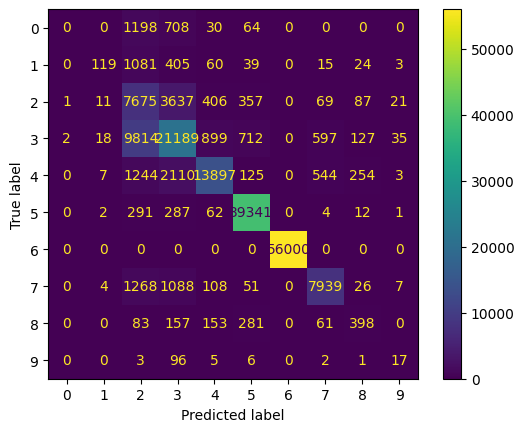

In [6]:
best_dt = DecisionTreeClassifier(**best_params)
best_dt.fit(x_train, y_train)

y_pred = best_dt.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, best_dt.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_dt.classes_)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "dt",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/UNSW/model.csv", mode='a', index=False)